In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
doc(search_images_ddg)

search_images_ddg(term, max_images=200)
Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [4]:
bear_types = 'grizzly','black','teddy'
path = Path('../data/images/bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear', max_images=200)
        download_images(dest, urls=results)

In [5]:
fns = get_image_files(path)
fns

(#577) [Path('../data/images/bears/grizzly/cabadfab-9436-4374-b3d9-bc2c3576d76f.jpg'),Path('../data/images/bears/grizzly/fd0047ad-e8e1-4a4d-9a46-c3ee3ea9bf1c.jpg'),Path('../data/images/bears/grizzly/3c687191-8a7f-4408-b9a1-556347e8d2d7.jpg'),Path('../data/images/bears/grizzly/e07f050d-cb7c-422f-b113-0684ae07a3b4.jpg'),Path('../data/images/bears/grizzly/23dbc74f-f182-4067-9aba-302b95fdd7eb.jpg'),Path('../data/images/bears/grizzly/ee875f94-f39d-4ba4-b1e6-18d5b5375ab1.jpg'),Path('../data/images/bears/grizzly/8dde91e0-67e4-4d61-95ec-e1f404ded4b2.jpg'),Path('../data/images/bears/grizzly/d7c329b3-ee14-4fe1-908c-e63b78914b5a.jpg'),Path('../data/images/bears/grizzly/71bf3503-8ac8-40e9-9940-b26235cefc6f.jpg'),Path('../data/images/bears/grizzly/0101fed0-eb81-4995-9c94-67309101ed47.jpg')...]

In [6]:
failed = verify_images(fns)
failed


(#0) []

In [7]:
failed.map(Path.unlink)


(#0) []

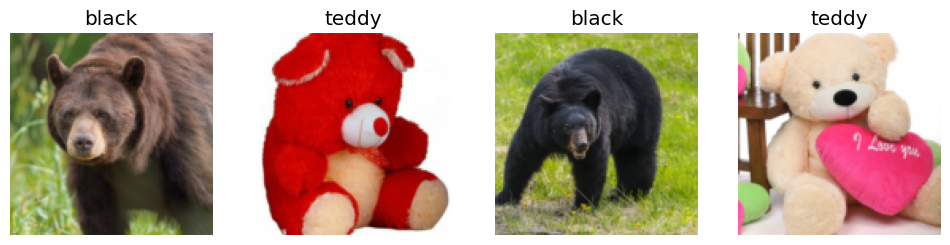

In [8]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

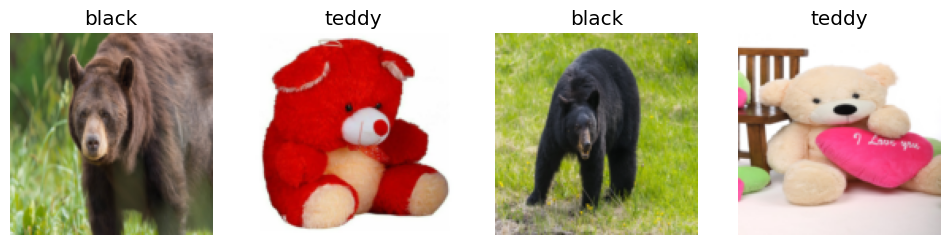

In [9]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

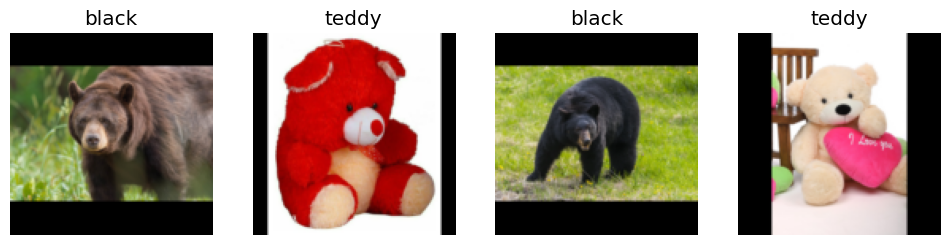

In [10]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

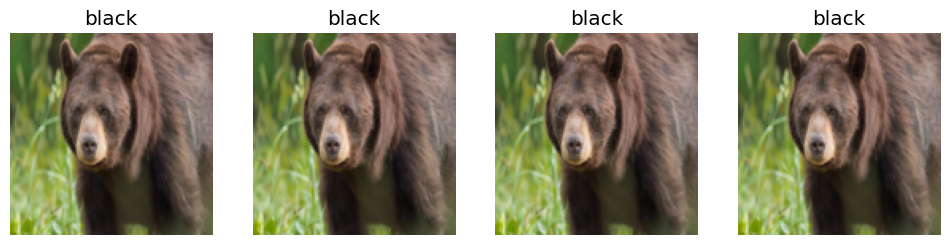

In [11]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

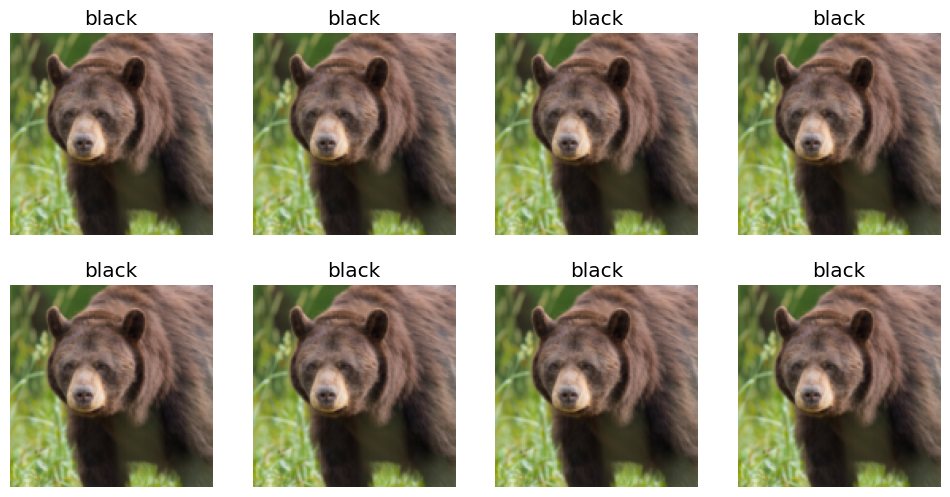

In [12]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2, unique=True)

In [13]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [14]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

/home/stephen/miniconda3/envs/fastbook/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/stephen/miniconda3/envs/fastbook/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.260461,0.029991,0.008696,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.103840,0.016875,0.008696,00:14
1,0.077959,0.014526,0.008696,00:13
2,0.070299,0.016864,0.008696,00:12
3,0.050935,0.017119,0.008696,00:14


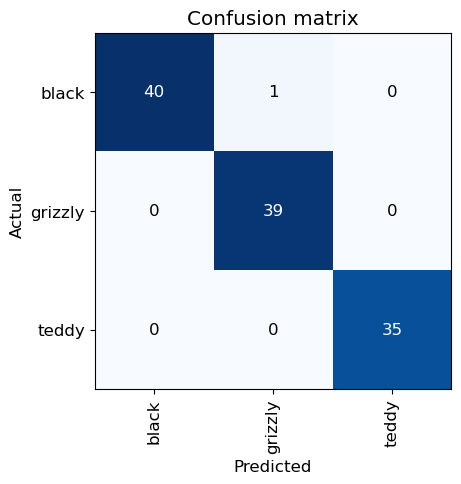

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

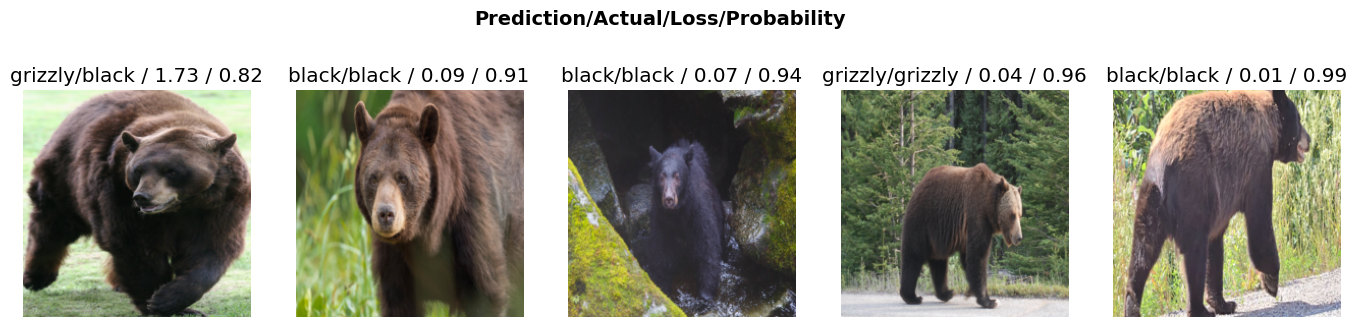

In [16]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In [17]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)